# Импорт MNIST

In [ ]:
# импорт самого важного
import numpy as np
np.random.seed(42)

In [ ]:
# функция для сортировки по таргету
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [ ]:
# имторт mnist
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [ ]:
# размер датасета (70000 экземпляров, в каждом из которых по 784 параметра = 28х28 пикселей)
mnist.data.shape

(70000, 784)

In [ ]:
# разделяем данные
X, y = mnist["data"], mnist["target"]

In [ ]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Посмотрим на 36000-й экземпляр набора данных

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

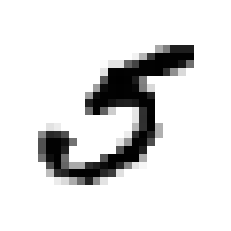

5

In [ ]:
# смотрим на одну цифру
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image,
           cmap=mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

y[36000]

In [ ]:
# функция для просмотра одного экземпляра
def plot_digit(data):
  image = data.reshape(28, 28)

  plt.imshow(image,
             cmap = mpl.cm.binary,
             interpolation="nearest")
  plt.axis("off")

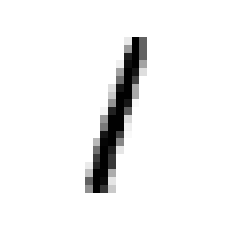

In [ ]:
plot_digit(X[12002])

Перетасуем обучающий набор данных, чтобы все блоки перекрестной проверки были похожими

In [ ]:
# разделение X и y на X_test и y_test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# массив из перемешанных 60000 значаний 
shuffle_index = np.random.permutation(60000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Бинарный классификатор

Попробуем обучить классификатор на распознавания только **прятерок**

In [ ]:
y_train_5 = (y_train == 5) # True для 5, False для всего остального
y_test_5 = (y_test == 5)

Созданим экземпляр SGDClassifier и обучим его

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42) # создание экземпляра класса SGD
sgd_clf.fit(X_train, y_train_5) # обучение классификатора

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [ ]:
sgd_clf.predict([some_digit]) # проверка работоспостобноти на одном экзмепляре

array([ True])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # кросс валидация

array([0.96225, 0.9645 , 0.94765])

### Реализация CV своими руками

In [ ]:
 from sklearn.model_selection import StratifiedKFold
 from sklearn.base import clone

 skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

 for train_index, test_index in skfolds.split(X_train, y_train_5):
   clone_clf = clone(sgd_clf)
   X_train_folds = X_train[train_index]
   y_train_folds = y_train_5[train_index]
   X_test_fold = X_train[test_index]
   y_test_fold = y_train_5[test_index]

   clone_clf.fit(X_train_folds, y_train_folds)
   y_pred = clone_clf.predict(X_test_fold)
   n_correct = sum(y_pred == y_test_fold)
   print(n_correct / len(y_pred))

0.9686
0.96205
0.9668


`accuracy` обычно не считается предпочитительным показателем производительности для классификаторов, особенно если мы работаем с ассиметричными наборами данных. В данном случае точность случайного угадывания "не пятерки" на всем наборе данных будет составлять 90%

Посмотрим на глупый классификатор

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

# Показетели поизводительности

### Матрица неточностей

Для расчета матрицы неточностей необходимо иметь набор прогнозов

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [ ]:
# создаем переменную с прогнозами на кросс-валдиации
y_train_pred = cross_val_predict(sgd_clf,
                                 X_train,
                                 y_train_5,
                                 cv=3)

# строим матрицу неточностей
confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]])

### Точность и полнота

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
# 3696/(3696+457)

0.7779476399770686

In [ ]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

### Среднее гарионическое (F1 - мера)

In [ ]:
from sklearn.metrics import f1_score
      
f1_score(y_train_5, y_train_pred)

0.7642200112633752

### Компромисс между precision и recall

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([150526.40944343])

In [ ]:
# уменьшили порог, ничего не изменилось
threeshold = 0

In [ ]:
y[36000]

5

In [ ]:
y_some_digit_pred = (y_scores > threeshold)
y_some_digit_pred

array([ True])

In [ ]:
# увеличили порог
threeshold = 20000

In [ ]:
y_some_digit_pred = (y_scores > threeshold)
y_some_digit_pred

array([ True])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method = "decision_function")

In [ ]:
y_scores.ndim

1

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
precisions

array([0.09093196, 0.09091672, 0.09091824, ..., 1.        , 1.        ,
       1.        ])

Точность и полнота как функции значения порога

In [ ]:
type(precisions)

numpy.ndarray

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, theresholds):
  plt.plot(theresholds, precisions[:-1], "b--", label="Точность", linewidth=2)
  plt.plot(theresholds, recalls[:-1], "g-", label="Полнота", linewidth=2)
  
  plt.xlabel("Порог", fontsize=16)
  plt.legend(loc="center left", fontsize=16)
#  plt.ylim([0, 1])

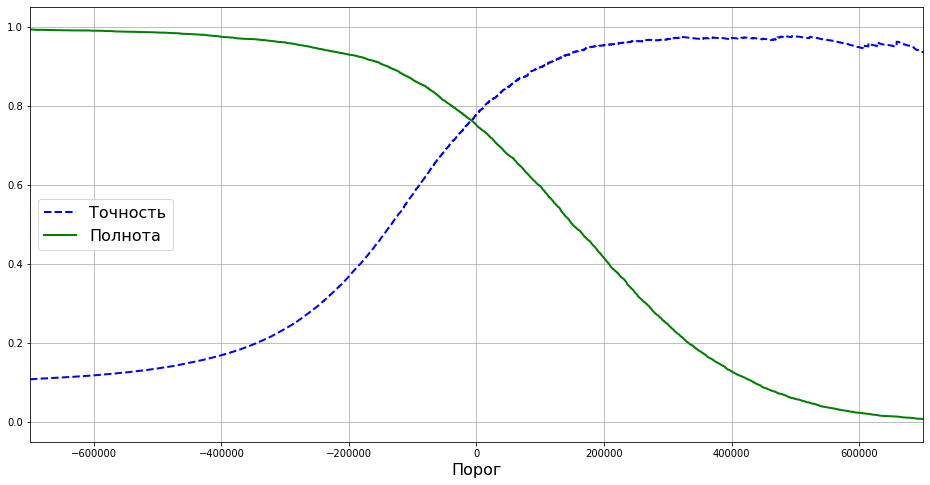

In [ ]:
plt.figure(figsize=(16, 8))
plt.xlim([-700000, 700000])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.grid()
plt.show()

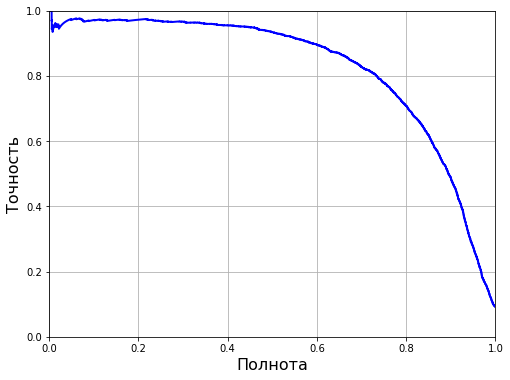

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Полнота", fontsize=16)
    plt.ylabel("Точность", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.grid()
plt.show()

In [ ]:
y_train_pred_90 = (y_scores > 70000)

Точность и полнота классификатора с порогом 70000

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.8712083540527101

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

### ROC кривая

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

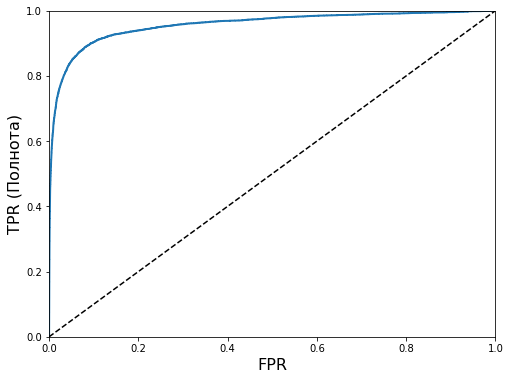

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel("FPR", fontsize=16)
  plt.ylabel("TPR (Полнота)", fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9562435587387078

Обучим Random Forest и построим ROC для обоих классификаторов

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10,
                                    random_state=42)
# используем метод predict_proba
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # оставляет вероятность отнесения только к классу 1
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

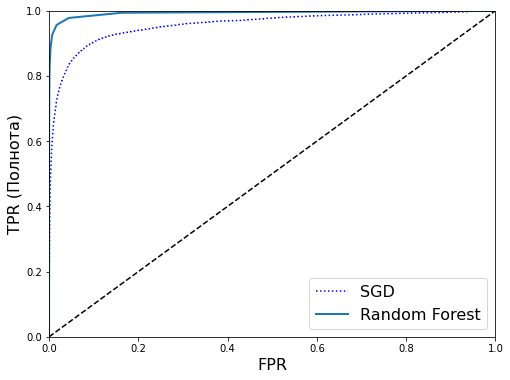

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

# Многоклассовая классификация

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7) # возвращет True на метки из трейна, которые >=7
y_train_odd = (y_train % 2 == 1) # возвращет True на нечетные числа

y_multilabel = np.c_[y_train_large, y_train_odd] # две целевые метки для каждого изображения цифры

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit]) # 5 не >= 7, и 5 это нечетное число

array([[False,  True]])

Обчно оценка сводится к тому, что для каждой отдельной метки посчитать F1 меру, а затем подсчитать среднюю сумму очков

In [ ]:
# F1 по всем меткам
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.97709078477525

# Многовыходовая классификация

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

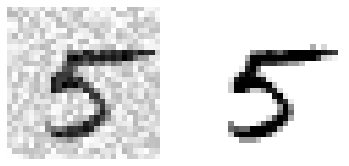

In [ ]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

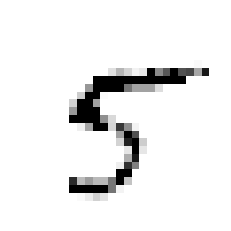

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)